In [1]:
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
test = pd.read_csv('dataset/data.csv')

In [4]:
train = pd.read_csv('dataset/train-processed.csv',names=["index", "score", "text"])

In [5]:
test.head()

,game_id,game_name,recommendation_id,user_id,num_games_owned,num_reviews,playtime_forever,playtime_at_review,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,1097150,Fall Guys,73899674,76561198104502231,52,22,658,253,"I gave a little Hug to a player, he stared bac...",1596781693,1,984,1451,0.947646,0,1,0,0
1,1097150,Fall Guys,73735619,76561198142247081,488,131,751,8,It's nice to have BR that's just about having ...,1596526002,1,2634,173,0.947115,18,1,0,0
2,1097150,Fall Guys,73738009,76561198041994478,1352,15,366,80,This game is fantastic. The devs are super inv...,1596529738,1,985,39,0.942068,1,1,0,0
3,1097150,Fall Guys,73848436,76561198025307988,1795,3,1672,866,"Fun in short bursts, tedious in long stretches...",1596693931,1,613,7,0.935590,12,0,1,0
4,1097150,Fall Guys,73781849,76561198089118754,50,2,203,30,wish there was an 8 party option,1596587937,1,553,6,0.935560,0,0,0,0


In [6]:
import re
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in test['review'].values: 
    line = str(line).lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

In [7]:
lines_without_stopwords=[] 
for line in train['text'].values: 
    line = str(line).lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
train_texts = lines_without_stopwords

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Found 18868 unique tokens.


In [11]:
embeddings_index = {}
f = open('glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [12]:
from keras.layers import Embedding
from keras.initializers import Constant
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(Embedding(num_words, 300, input_length=100, weights= [embedding_matrix], trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
from tensorflow import keras
model = keras.models.load_model('model/glove')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
labels = model.predict(data)

In [23]:
labels

array([[0.0079563 , 0.6128424 , 0.16639858, 0.21774891, 0.0061959 ],
       [0.00315255, 0.07512492, 0.06195897, 0.70706564, 0.19137171],
       [0.00233465, 0.10571408, 0.05703959, 0.70704067, 0.1415563 ],
       ...,
       [0.00618428, 0.20777705, 0.16715461, 0.507881  , 0.06533644],
       [0.00245377, 0.1932432 , 0.05669454, 0.6475827 , 0.08944112],
       [0.01227832, 0.453731  , 0.2811484 , 0.22463043, 0.01848796]],
      dtype=float32)

In [40]:
l = []
for e in labels:
    score = 0
    for i in range(len(e)):
        score = score + e[i]*i
    l.append(score)

In [41]:
l

[1.6236698925495148,
 3.0857266187667847,
 2.9071404337882996,
 1.9298013746738434,
 1.8876858949661255,
 2.3890554904937744,
 2.4221176505088806,
 1.733898639678955,
 1.8903782963752747,
 2.3723923563957214,
 2.7765159606933594,
 2.7195772230625153,
 2.2544447779655457,
 1.7845221757888794,
 2.260501444339752,
 2.258390426635742,
 2.0126092433929443,
 2.543639898300171,
 1.7864717841148376,
 1.8899328708648682,
 1.9774978160858154,
 1.8899328708648682,
 2.5138601660728455,
 2.117025315761566,
 1.8484115600585938,
 2.478707045316696,
 2.40436327457428,
 2.3002249598503113,
 2.7112194895744324,
 1.8876858949661255,
 1.8876859545707703,
 1.842080295085907,
 1.688555359840393,
 2.393687814474106,
 1.9662655889987946,
 2.787358343601227,
 2.5236461460590363,
 1.7242859601974487,
 1.803639829158783,
 2.190377652645111,
 1.9076768159866333,
 2.470466911792755,
 1.6883407235145569,
 2.221513658761978,
 1.9736663103103638,
 1.7695089280605316,
 1.784320592880249,
 1.616772085428238,
 2.0031256

In [50]:
y_classes = labels.argmax(axis=-1)

Text(0, 0.5, 'count')

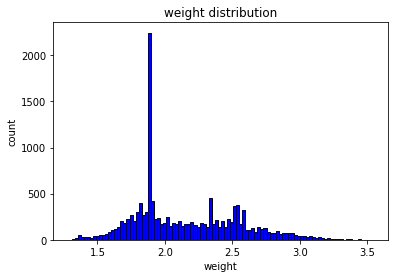

In [30]:
import seaborn as sns

# matplotlib histogram
plt.hist(l, color = 'blue', edgecolor = 'black',
         bins = 100)
sns.distplot(l, hist=True, kde=False, 
             bins= 100, color = 'blue')
# Add labels
plt.title('weight distribution')
plt.xlabel('weight')
plt.ylabel('count')

In [51]:
for i in range(len(y_classes)):
    if l[i]<1.5:
        y_classes[i] = 0
    elif l[i]>3:
        y_classes[i] = 4

In [52]:
import collections
collections.Counter(y_classes)

Counter({1: 6271, 4: 348, 3: 7155, 0: 236, 2: 26})

In [53]:
test['predict']= y_classes

In [66]:
t = test[['review','predict']]

In [67]:
t.to_csv('dataset/predicted.csv')